## Import Library

In [1]:
import os
import re
import string
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.max_columns', None)

## Load dataset

In [2]:
import pickle

data_filename = 'GSPP11_data_merge'

try:
    df = pickle.load(open(data_filename + '.pickle', 'rb'))
except (OSError, IOError) as e:
    df = pd.read_excel(data_filename + '.xlsx')
    pickle.dump(df, open(data_filename + '.pickle', 'wb'))

df.head()

,Date,Condition,GT Number,GT ACTIVE POWER,AMBIENT PRESSURE SELECTED VALUE 1,AMBIENT PRESSURE SELECTED VALUE 2,AMBIENT PRESSURE Point 1,AMBIENT PRESSURE Point 2,GT INLET SCREEN DIFF. PRESS.,GT INLET AIR DIFF. PRESS.,GT INLET FILTER HOUSE AIR TEMP. 1,GT INLET FILTER HOUSE AIR TEMP. 2,GT INLET FILTER HOUSE AIR HUMIDITY 1,GT INLET FILTER HOUSE AIR HUMIDITY 2,No.1 GT CHILLED WATER SUPPLY TEMP.,SPRINT WATER FLOW,LP SPRINT TOTAL WATER FLOW,LP SPRINT OPERATION HOUR,VIGV POSITION SELECTED,#1 VIGV POSITION,#2 VIGV POSITION,VBVBEL POSITION SELECTED,VSVSEL POSITION SELECTED,No.1 INLET AIR HEATER LEVEL CV POS. DEMAND,LP COMP. INLET TEMP. (T2) SELECTED,GT INLET TEMP. (T10) SELECTED,HP COMP. INLET TEMP. (T25) SELECTED,HP COMP. DISCH. TEMP. (T3) SELECTED,#1 HP COMP. INLET PRESS. (P25),#2 HP COMP. INLET PRESS. (P25),#1 HP COMP. DISCH. PRESS. (PS3),#2 HP COMP. DISCH. PRESS. (PS3),LP TURBINE INLET TEMP. (T48) SELECTED,DIFFERENACE OF T48MAX AND T48MIN,HP ROTOR SPEED (XN25) SELECTED,LP ROTOR SPEED (XNSD) SELECTED,Fuel Gas Volume Flow,LOWER HEATING VALUE 1,LOWER HEATING VALUE 2,Fuel Specific Gravity Selected,Compressibility Factor Selected,FUEL GAS SUPPLY PRESS.,FUEL GAS SUPPLY TEMP. SELECTED,Curnt. Methane (C1),Curnt. Ethane (C2),Curnt. Propane (C3),Curnt. i-Butane (iC4),Curnt. n-Butene (nC4),Curnt. i-Pentane (iC5),Curnt. n-Pentane (nC5),Curnt. Hexane Plus (C6+),Curnt. Nitrogen (N2),Curnt. Carbon Dioxide (CO2),HRSG INLET FUEL GAS PRESS.,HRSG INLET GAS DUCT TEMP. #1,HRSG INLET GAS DUCT TEMP. #2,HRSG OUTLET FUEL GAS PRESS.,HRSG OUTLET GAS DUCT TEMP. #1,HRSG OUTLET GAS DUCT TEMP. #2,LP TURBINE INLET TEMP. (T48) A,LP TURBINE INLET TEMP. (T48) B,LP TURBINE INLET TEMP. (T48) C,LP TURBINE INLET TEMP. (T48) D,LP TURBINE INLET TEMP. (T48) E,LP TURBINE INLET TEMP. (T48) F,LP TURBINE INLET TEMP. (T48) G,LP TURBINE INLET TEMP. (T48) H
0,2019-01-01 00:00:00,Normal,1,24.961611,14.445444,14.466763,1002.279208,1002.764703,0.579197,-0.876408,24.942641,24.955787,58.258275,59.779050,44.426224,0.005570,98132.634463,465.728370,28.269185,28.804726,27.735972,13.471984,72.954904,72.223297,40.599394,41.138421,121.961115,530.589712,201.459786,201.734075,2061.697022,2064.664860,852.376481,24.547630,10089.833398,3629.223758,193.406986,45657.459423,45700.301860,0.594959,0.943591,4.360250,58.322947,95.124280,0.993676,0.109514,0.027650,0.026884,0.003666,0.002890,0.009909,1.968795,1.732711,0.097487,488.504492,486.230573,0.041327,89.307232,102.802245,847.066968,863.186131,853.090418,858.288423,838.633159,859.917953,847.319691,850.996004
1,2019-01-01 01:00:00,Normal,1,24.955444,14.449742,14.466154,1002.073566,1002.430513,0.577017,-0.874152,24.495615,24.543611,58.275939,60.006663,44.912449,0.005458,98132.645325,465.729958,28.258613,28.784903,27.733255,13.214311,72.702084,69.044871,40.933119,41.474002,122.625872,531.528906,201.763867,202.032457,2062.207612,2064.943401,852.605385,24.563439,10089.025464,3629.442142,193.345791,45608.743144,45649.098929,0.595003,0.943467,4.360398,58.372839,95.081885,1.016808,0.102702,0.025571,0.024688,0.002276,0.001772,0.009802,1.969856,1.764604,0.110897,488.856580,486.545500,0.029931,89.151650,102.703886,847.225598,863.341621,853.268686,858.476324,838.720686,860.321558,847.653442,851.321655
2,2019-01-01 02:00:00,Normal,1,25.000464,14.452401,14.465545,1001.667664,1002.095941,0.576373,-0.874066,23.527854,23.712178,60.139831,61.588245,44.869438,0.005346,98132.656186,465.731547,28.235135,28.751349,27.717824,13.006690,72.625770,70.603622,40.795232,41.373230,122.755831,531.591234,202.296723,202.565203,2064.342381,2067.248927,852.410639,24.377013,10087.886271,3630.881414,192.986560,45572.619074,45612.402519,0.595048,0.943500,4.360448,57.630118,95.046427,1.030336,0.104356,0.025849,0.025095,0.002420,0.001761,0.004824,1.960737,1.798180,0.099417,488.327492,486.011030,0.018535,89.075548,102.628714,847.218651,863.074201,853.051051,857.873665,838.672786,860.240772,847.339965,851.294517
3,2019-01-01 03:00:00,Normal,1,24.991005,14.455040,14.464936,1001.346888,1001.791

## Prepare dataset

In [3]:
df['Condition'] = [0 if val == 'Normal' else 1 for val in df['Condition']]
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

# Fill all NaN with value = 0
nan_df = df[df.isnull().any(axis=1)]
df.iloc[:, 3:] = df.iloc[:, 3:].fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29232 entries, 0 to 29231
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date                                        29232 non-null  datetime64[ns]
 1   Condition                                   29232 non-null  int64         
 2   GT Number                                   29232 non-null  int64         
 3   GT ACTIVE POWER                             29232 non-null  float64       
 4   AMBIENT PRESSURE SELECTED VALUE 1           29232 non-null  float64       
 5   AMBIENT PRESSURE SELECTED VALUE 2           29232 non-null  float64       
 6   AMBIENT PRESSURE Point 1                    29232 non-null  float64       
 7   AMBIENT PRESSURE Point 2                    29232 non-null  float64       
 8   GT INLET SCREEN DIFF. PRESS.                29232 non-null  float64       
 9   GT INL

In [4]:
print('List of {:d} NaN rows in df:'.format(len(nan_df)), list(nan_df.index))

List of 320 NaN rows in df: [5052, 5053, 5054, 5055, 5339, 6563, 6564, 6565, 6566, 10596, 11770, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14614, 14615, 19668, 19669, 19670, 19671, 25114, 25115, 25116, 25117, 25118, 25119, 25120, 25121, 25122, 25123, 25124, 25125, 25126, 25127, 25128, 25129, 25130, 25131, 25132, 25133, 25134, 25135, 25136, 25137, 25138, 25139, 25140, 25141, 25142, 25143, 25144, 25145, 25146, 25147, 25148, 25149, 25150, 25151, 25152, 25153, 25154, 25155, 25156, 25157, 25158, 25159, 25160, 25161, 25162, 25163, 25164, 25165, 25166, 25167, 25168, 25169, 25170, 25171, 25172, 25173, 25174, 25175, 25176, 25177, 25178, 25179, 25180, 25181, 25182, 25183, 25184, 25185, 25186, 25187, 25188, 25189, 25190, 25191, 25192, 25193, 25194, 25195, 25196, 25197, 25198, 25199, 25200, 25201, 25202, 25203, 25204, 25205, 25206, 25207, 25208, 25209, 25210, 25211, 25212, 25213, 25214, 25215, 25216, 25217, 25218, 25219, 25220, 25221, 25222, 25223, 

In [5]:
# Scaling value of features in range of (0,1)

from sklearn.preprocessing import MinMaxScaler

features = df.iloc[:, 3:]
scaler = MinMaxScaler((0, 1)).fit(features)

scaled_df = df
scaled_df.iloc[:, 3:] = scaler.transform(scaled_df.iloc[:, 3:])

In [6]:
# Split data
from sklearn.model_selection import train_test_split

norm_df = scaled_df[scaled_df['Condition'] == 0]
train_df, val_df = train_test_split(scaled_df, test_size=0.2, random_state=42)
val_df, norm_test_df = train_test_split(val_df, test_size=0.2, random_state=42)

print('Total samples: {:,d}'.format(len(scaled_df)))
print('Normal samples: {:,d}, Abnormal samples: {:,d}'.format(len(norm_df), len(scaled_df)-len(norm_df)))
print()

print('Normal samples split for train/val/test in ratio of {:,d}/{:,d}/{:,d} samples ({:.1f}/{:.1f}/{:.1f}%)'.format(
    len(train_df), len(val_df), len(norm_test_df), 100*len(train_df)/len(scaled_df), 100*len(val_df)/len(scaled_df), 100*len(norm_test_df)/len(scaled_df)))
print()

abnorm_df = scaled_df[scaled_df['Condition'] == 1]
test_df = norm_test_df.append(abnorm_df)
print('Merging normal test samples with abnormal samples for test, total test samples: {:,d}+{:,d} = {:,d} samples'.format(len(norm_test_df), len(abnorm_df), len(test_df)))

Total samples: 29,232
Normal samples: 23,517, Abnormal samples: 5,715

Normal samples split for train/val/test in ratio of 23,385/4,677/1,170 samples (80.0/16.0/4.0%)

Merging normal test samples with abnormal samples for test, total test samples: 1,170+5,715 = 6,885 samples


In [7]:
train_data = train_df.drop(columns=['Date', 'Condition', 'GT Number']).to_numpy()
val_data = val_df.drop(columns=['Date', 'Condition', 'GT Number']).to_numpy()
test_data = test_df.drop(columns=['Date', 'Condition', 'GT Number']).to_numpy()

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_data)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_data)).batch(batch_size)

buffer_size = 32
train_ds = train_ds.prefetch(buffer_size=buffer_size)
val_ds = val_ds.prefetch(buffer_size=buffer_size)
test_ds = test_ds.prefetch(buffer_size=buffer_size)

## Build a model

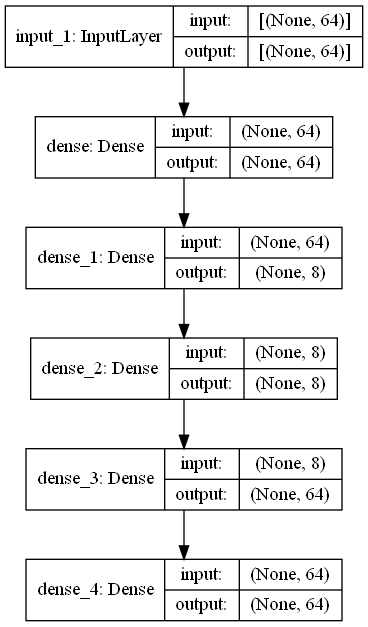

In [8]:
# Model name
model_name = 'model_2'

def make_model(features_number):

    # Encoder
    inputs = layers.Input(shape=(features_number, ))
    x = layers.Dense(64, activation='relu')(inputs)
    # x = layers.Dropout(rate=0.2)(x)
    # x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)

    # Decoder
    x = layers.Dense(8, activation='relu')(x)
    # x = layers.Dropout(rate=0.2)(x)
    # x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(features_number)(x)

    return keras.Model(inputs, outputs, name='autoencoder')

model = make_model(features_number=len(features.columns))
keras.utils.plot_model(model, to_file=model_name + '.png', show_shapes=True)
# model.summary()

## Train the model

In [52]:
import datetime

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['accuracy'],
)

# Tensorboard
tb = keras.callbacks.TensorBoard(
    log_dir='logs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
)

# Checkpoint
cp = keras.callbacks.ModelCheckpoint(
    filepath=model_name + '/' + model_name + '-{epoch:05d}.h5',
    verbose=0,
    save_weights_only=True,
    save_freq=7310,
)
try:
    saved_model_name = 'model_1-02130'
    model.load_weights(model_name + '/' + saved_model_name + '.h5')
    initial_epoch = int(saved_model_name.split('-')[1])
except (OSError, IOError) as e:
    initial_epoch = 0

model.fit(train_ds, epochs=1, initial_epoch=initial_epoch, validation_data=val_ds, verbose=1, callbacks=[tb, cp])

In [47]:
for ds in [train_ds, val_ds, test_ds]:
    print(model.evaluate(ds)[0])

731/731 [==============================] - 1s 2ms/step - loss: 5.7018e-04 - accuracy: 0.5869
0.0005701775662600994
147/147 [==============================] - 0s 2ms/step - loss: 6.1038e-04 - accuracy: 0.5848
0.000610382470767945
216/216 [==============================] - 0s 2ms/step - loss: 7.2134e-04 - accuracy: 0.5615
0.0007213361095637083


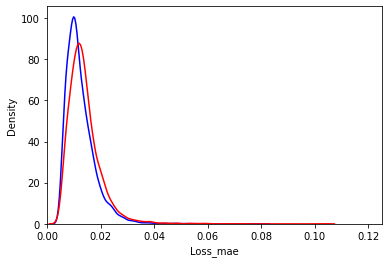

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Normal data
X = norm_df.drop(columns=['Date', 'Condition', 'GT Number'])
Y = pd.DataFrame(model.predict(X.to_numpy()), index=X.index, columns=X.columns)

norm_scored = pd.DataFrame(index=X.index)
norm_scored['Loss_mae'] = np.mean(np.abs(Y-X), axis=1)
norm_scored

# Abnormal data
X = abnorm_df.drop(columns=['Date', 'Condition', 'GT Number'])
Y = pd.DataFrame(model.predict(X.to_numpy()), index=X.index, columns=X.columns)

abnorm_scored = pd.DataFrame(index=X.index)
abnorm_scored['Loss_mae'] = np.mean(np.abs(Y-X), axis=1)

# Plot
plt.figure()
plt.xlim([0.0, 0.125])
sns.distplot(norm_scored['Loss_mae'], bins=30, kde=True, color='blue', hist_kws=dict(edgecolor="k", linewidth=1), hist=False)
sns.distplot(abnorm_scored['Loss_mae'], bins=30, kde=True, color='red', hist_kws=dict(edgecolor="k", linewidth=1), hist=False)
plt.show()